In [3]:
"""
This code makes diagnostic plots for raw and postprocessed WRF-Solar output
Postprocessing using the Kalman Filter is from Rafael Alvarenga's code (rafael.alvarenga@etu.univ-guyane.fr)
"""
import glob
import os
from file_func import *
from plotting import *
from __const__ import *


In [4]:
li = pd.DataFrame()
method= 'KF'
nb_historical_days = 15
for ens in ['ens0','ens1','ens2','ens3','ensmean']:
    for domain in ['d01', 'd02']:
        dir_path_recursive = f'{main_dir_path_recursive}/{ens}/{domain}/{station_name}/{nb_historical_days}_day_{method}'
        all_files = glob.glob(dir_path_recursive + "/*_df.csv")

        for filename in all_files:
            df = pd.read_csv(filename)
            df['rmse_mod'] = fitting(df)[7]
            df['r_mod'] = fitting(df)[0]
            
            df['kfp_rmse'] = fitting_pred(df)[7]
            df['kfp_r'] = fitting_pred(df)[0]
            
            df['kf_rmse'] = kf_fitting_pred(df)[7]
            df['kf_r'] = kf_fitting_pred(df)[0]
            
            li = li.append(df)
            print(filename)


output/ens0/d01/MO/15_day_KF/ens0_d01_15_day_KF_df.csv
output/ens0/d02/MO/15_day_KF/ens0_d02_15_day_KF_df.csv
output/ens1/d01/MO/15_day_KF/ens1_d01_15_day_KF_df.csv
output/ens1/d02/MO/15_day_KF/ens1_d02_15_day_KF_df.csv
output/ens2/d01/MO/15_day_KF/ens2_d01_15_day_KF_df.csv
output/ens2/d02/MO/15_day_KF/ens2_d02_15_day_KF_df.csv
output/ens3/d01/MO/15_day_KF/ens3_d01_15_day_KF_df.csv
output/ens3/d02/MO/15_day_KF/ens3_d02_15_day_KF_df.csv
output/ensmean/d01/MO/15_day_KF/ensmean_d01_15_day_KF_df.csv
output/ensmean/d02/MO/15_day_KF/ensmean_d02_15_day_KF_df.csv


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/134545878.py:83: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"output/models_Manila_scatplot.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


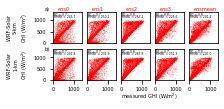

In [43]:
#row 1: ghi_mod

def scat_model(da_mean):   
    
    
    x_new = np.linspace(0.01, 1360, 1000)
    fig = plt.figure()
    gs = fig.add_gridspec(6, 10)
    
    

    jump = 1 #2   
    i_end = 2 #5
    j_end = 5 #9
    for i in range(0,i_end,jump):
        for j in range(0,j_end,jump):

            ax= fig.add_subplot(gs[i:i+1,j:j+1])


            if ((i == 0)):
                ax.tick_params(axis='x', bottom=False,top=False,labelbottom=False) 
            if (j > 0):
                ax.tick_params(axis='y', left=False,right=False,labelleft=False) 

            if (j == 0):
                ens = 'ens0'
                back = da_mean[da_mean['ens'] == ens]
                
            if (j == 1):
                ens = 'ens1'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 2):
                ens = 'ens2'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 3):
                ens = 'ens3'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 4):
                ens = 'ensmean'
                back = da_mean[da_mean['ens'] == ens]
            
            if (i == 0): 
                color_= 'red'
                back = back[back['domain'] == 'd01']
                method = 'WRF-Solar \n5-km'
            
            if (i == 1):     
                color_= 'red'
                back = back[back['domain'] == 'd02']
                method = 'WRF-Solar \n1-km'
                

            rmse = back['rmse_mod'].mean()
            r_ = back['r_mod'].mean()
                
            ax.scatter(x=back['ghi_obs'],y=back['ghi_mod'],c=color_,s=0.01,alpha=0.5)
            plt.plot(x_new,x_new,c='gray',linewidth=0.1)
            ax.text( 50, 1100,'RMSE = %0.1f'%rmse, fontsize=3, color='black')
            ax.text( 50, 1200,'R* = %0.1f'%r_, fontsize=3, color='black')

            ax.tick_params(axis='both', which='major', labelsize=5)
            ax.set_ylim(0,1360)
            ax.set_xlim(0,1360)

            if (j==0):
                ax.set_ylabel(f'{method}\nGHI (W/m$^2$)',  fontsize=5)  

            if ((i==0) & (j==0)):
                ax.text( -400, 1400,'a)', fontsize=5, color='k')
            if ((i==1) & (j==0)):
                ax.text( -400, 1300,'b)', fontsize=5, color='k')

            if (i==0):
                ax.text( 200, 1400,ens, fontsize=5, color=color_)
            if ((i==1) & (j==2)):
                ax.text( 0, -800,f'measured GHI (W/m$^2$)', fontsize=5, color='k')


    plt.savefig(f"output/models_Manila_scatplot.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_model(li)


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/2682254664.py:84: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"output/models_cloudy_Manila_scatplot.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


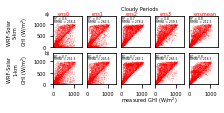

In [44]:
#row 1: ghi_mod

def scat_model_cloudy(da_mean):   
    
    da_mean = da_mean[da_mean['flag_clear'] == 'N']
    x_new = np.linspace(0.01, 1360, 1000)
    fig = plt.figure()
    gs = fig.add_gridspec(6, 10)
    
    

    jump = 1 #2   
    i_end = 2 #5
    j_end = 5 #9
    for i in range(0,i_end,jump):
        for j in range(0,j_end,jump):

            ax= fig.add_subplot(gs[i:i+1,j:j+1])


            if ((i == 0)):
                ax.tick_params(axis='x', bottom=False,top=False,labelbottom=False) 
            if (j > 0):
                ax.tick_params(axis='y', left=False,right=False,labelleft=False) 

            if (j == 0):
                ens = 'ens0'
                back = da_mean[da_mean['ens'] == ens]
                
            if (j == 1):
                ens = 'ens1'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 2):
                ens = 'ens2'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 3):
                ens = 'ens3'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 4):
                ens = 'ensmean'
                back = da_mean[da_mean['ens'] == ens]
            
            if (i == 0): 
                color_= 'red'
                back = back[back['domain'] == 'd01']
                method = 'WRF-Solar \n5-km'
            
            if (i == 1):     
                color_= 'red'
                back = back[back['domain'] == 'd02']
                method = 'WRF-Solar \n1-km'
                
            rmse = fitting(back)[7]
            r_ =  fitting(back)[0]
                
            ax.scatter(x=back['ghi_obs'],y=back['ghi_mod'],c=color_,s=0.01,alpha=0.5)
            plt.plot(x_new,x_new,c='gray',linewidth=0.1)
            ax.text( 50, 1100,'RMSE = %0.1f'%rmse, fontsize=3, color='black')
            ax.text( 50, 1200,'R* = %0.1f'%r_, fontsize=3, color='black')

            ax.tick_params(axis='both', which='major', labelsize=5)
            ax.set_ylim(0,1360)
            ax.set_xlim(0,1360)

            if (j==0):
                ax.set_ylabel(f'{method}\nGHI (W/m$^2$)',  fontsize=5)  
                
            if ((i==0) & (j==0)):
                ax.text( -400, 1400,'a)', fontsize=5, color='k')
            if ((i==1) & (j==0)):
                ax.text( -400, 1300,'b)', fontsize=5, color='k')
                
            if (i==0):
                ax.text( 200, 1400,ens, fontsize=5, color=color_)
            if ((i==0) & (j==2)):
                ax.text( 0, 1600,'Cloudy Periods', fontsize=5, color='k')
            if ((i==1) & (j==2)):
                ax.text( 0, -800,f'measured GHI (W/m$^2$)', fontsize=5, color='k')


    plt.savefig(f"output/models_cloudy_Manila_scatplot.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_model_cloudy(li)


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/3697344101.py:87: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"output/models_clear_Manila_scatplot.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


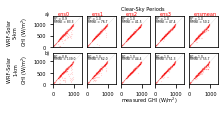

In [69]:
#row 1: ghi_mod

def scat_model_clear(da_mean):   
    
    da_mean = da_mean[da_mean['flag_clear'] == 'Y']
    x_new = np.linspace(0.01, 1360, 1000)
    fig = plt.figure()
    gs = fig.add_gridspec(6, 10)
    
    

    jump = 1 #2   
    i_end = 2 #5
    j_end = 5 #9
    for i in range(0,i_end,jump):
        for j in range(0,j_end,jump):

            ax= fig.add_subplot(gs[i:i+1,j:j+1])


            if ((i == 0)):
                ax.tick_params(axis='x', bottom=False,top=False,labelbottom=False) 
            if (j > 0):
                ax.tick_params(axis='y', left=False,right=False,labelleft=False) 

            if (j == 0):
                ens = 'ens0'
                back = da_mean[da_mean['ens'] == ens]
                
            if (j == 1):
                ens = 'ens1'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 2):
                ens = 'ens2'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 3):
                ens = 'ens3'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 4):
                ens = 'ensmean'
                back = da_mean[da_mean['ens'] == ens]
            
            if (i == 0): 
                color_= 'red'
                back = back[back['domain'] == 'd01']
                method = 'WRF-Solar \n5-km'
            
            if (i == 1):     
                color_= 'red'
                back = back[back['domain'] == 'd02']
                method = 'WRF-Solar \n1-km'
                

            rmse = fitting(back)[7]
            r_ =  fitting(back)[0]
            
            ax.scatter(x=back['ghi_obs'],y=back['ghi_mod'],c=color_,s=0.01,alpha=0.5)
            plt.plot(x_new,x_new,c='gray',linewidth=0.1)
            ax.text( 50, 1100,'RMSE = %0.1f'%rmse, fontsize=3, color='black')
            ax.text( 50, 1200,'R* = %0.1f'%r_, fontsize=3, color='black')

            ax.tick_params(axis='both', which='major', labelsize=5)
            ax.set_ylim(0,1360)
            ax.set_xlim(0,1360)


            if (j==0):
                ax.set_ylabel(f'{method}\nGHI (W/m$^2$)',  fontsize=5)  

            if (i==0):
                ax.text( 200, 1400,ens, fontsize=5, color=color_)
                
            if ((i==0) & (j==0)):
                ax.text( -400, 1400,'a)', fontsize=5, color='k')
            if ((i==1) & (j==0)):
                ax.text( -400, 1300,'b)', fontsize=5, color='k')
            
            if ((i==0) & (j==2)):
                ax.text( 0, 1600,'Clear-Sky Periods', fontsize=5, color='k')
            if ((i==1) & (j==2)):
                ax.text( 0, -800,f'measured GHI (W/m$^2$)', fontsize=5, color='k')


    plt.savefig(f"output/models_clear_Manila_scatplot.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_model_clear(li)


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/2243995778.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['ghi_mod']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/2243995778.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['ghi_mod']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/2243995778.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/2243995778.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['GHI_pred_kf_only']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/2243995778.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['GHI_pred_kf_only']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/2243995778.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

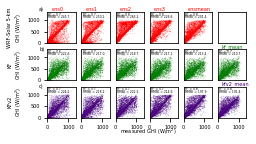

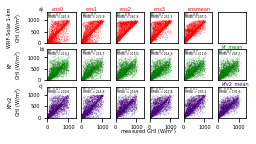

In [52]:
#row 1: ghi_mod

#row 2: 'GHI_pred_kf_only'

#row 3: 'GHI_pred_improved_fin'

def scat_all(domain, da_mean):   
    plt_da = da_mean
    
    li_gr = da_mean[da_mean['domain'] == str(domain)]
    li_gr = li_gr.groupby(['Time']).agg({'GHI_pred_kf_only':'mean','ghi_obs':'mean'}).reset_index()
    li_gr['kf_rmse'] = kf_fitting_pred(li_gr)[7]
    li_gr['kf_r'] = kf_fitting_pred(li_gr)[0]

    li_gr2 = da_mean[da_mean['domain'] == str(domain)]
    li_gr2 = li_gr2.groupby(['Time']).agg({'GHI_pred_improved_fin':'mean','ghi_obs':'mean'}).reset_index()
    li_gr2['kfp_rmse'] = fitting_pred(li_gr2)[7]
    li_gr2['kfp_r'] = fitting_pred(li_gr2)[0]
    
    x_new = np.linspace(0.01, 1360, 1000)
    fig = plt.figure()
    gs = fig.add_gridspec(6, 10)
    
    da_mean = da_mean[da_mean['domain'] == str(domain)]
    if domain == 'd01':
            res = 5
    elif domain == 'd02':
            res = 1
    jump = 1 #2   
    i_end = 3 #5
    j_end = 6 #9
    for i in range(0,i_end,jump):
        for j in range(0,j_end,jump):

            ax= fig.add_subplot(gs[i:i+1,j:j+1])


            if ((i == 0) | (i == 1)):
                ax.tick_params(axis='x', bottom=False,top=False,labelbottom=False) 
            if (j > 0):
                ax.tick_params(axis='y', left=False,right=False,labelleft=False) 

            if (j == 0):
                ens = 'ens0'
                back = da_mean[da_mean['ens'] == ens]
                
            if (j == 1):#2):
                ens = 'ens1'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 2):#4):
                ens = 'ens2'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 3):#6):
                ens = 'ens3'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 4):#8):
                ens = 'ensmean'
                back = da_mean[da_mean['ens'] == ens]
            
            if ((i == 1) & (j == 5)):
                ens = 'kf_mean'
                back = li_gr
                back['pl'] = back['GHI_pred_kf_only']   

            if ((i == 2) & (j == 5)):
                ens = 'kfv2_mean'
                back = li_gr2
                back['pl'] = back['GHI_pred_improved_fin']   

            if ((i == 0) & (j != 5)):
                method = f'WRF-Solar {res}-km'
                color_= 'red'
                back['pl'] = back['ghi_mod']
                rmse = back['rmse_mod'].mean()
                r_ = back['r_mod'].mean()
            if (i == 1):#2):
                method = 'KF'
                color_= 'green'
                back['pl'] = back['GHI_pred_kf_only']   
                rmse = back['kf_rmse'].mean()
                r_ = back['kf_r'].mean()
            if ((i == 2)):#4):
                method = 'KFv2'
                color_= 'indigo'
                back['pl'] = back['GHI_pred_improved_fin']
                rmse = back['kfp_rmse'].mean()
                r_ = back['kfp_r'].mean()
            
            if (((i == 0) & (j != 5)) | ((i != 0) & (j <= 5))):
                
                ax.scatter(x=back['ghi_obs'],y=back['pl'],c=color_,s=0.01,alpha=0.5)
                plt.plot(x_new,x_new,c='gray',linewidth=0.1)
                ax.text( 50, 1100,'RMSE = %0.1f'%rmse, fontsize=3, color='black')
                ax.text( 50, 1200,'R* = %0.1f'%r_, fontsize=3, color='black')

                ax.tick_params(axis='both', which='major', labelsize=5)
                ax.set_ylim(0,1360)
                ax.set_xlim(0,1360)

                if (j==0):
                    ax.set_ylabel(f'{method}\nGHI (W/m$^2$)',  fontsize=5)  

                if (i==0) | ((i!=0 ) & (j==5)):
                    ax.text( 200, 1400,ens, fontsize=5, color=color_)
                if ((i==2) & (j==2)):
                    ax.text( 200, -700,f'measured GHI (W/m$^2$)', fontsize=5, color='k')
                if ((i==0) & (j==0)):
                    ax.text( -400, 1400,'a)', fontsize=5, color='k')
                if ((i==1) & (j==0)):
                    ax.text( -400, 1300,'b)', fontsize=5, color='k')
                if ((i==2) & (j==0)):
                    ax.text( -400, 1300,'c)', fontsize=5, color='k')

    plt.savefig(f"output/all_Manila_scatplot_{res}km_{domain}.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_all('d01',li)
scat_all('d02',li)


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/962394886.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['ghi_mod']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/962394886.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['ghi_mod']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/962394886.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/962394886.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['GHI_pred_kf_only']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/962394886.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['GHI_pred_kf_only']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/962394886.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

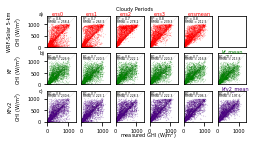

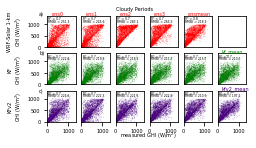

In [67]:
#row 1: ghi_mod

#row 2: 'GHI_pred_kf_only'

#row 3: 'GHI_pred_improved_fin'

def scat_cloudy(domain, da_mean):   
    da_mean = da_mean[da_mean['flag_clear'] == 'N']
    
    li_gr = da_mean[da_mean['domain'] == str(domain)]
    li_gr = li_gr.groupby(['Time']).agg({'GHI_pred_kf_only':'mean','ghi_obs':'mean'}).reset_index()
    li_gr['kf_rmse'] = kf_fitting_pred(li_gr)[7]
    li_gr['kf_r'] = kf_fitting_pred(li_gr)[0]

    li_gr2 = da_mean[da_mean['domain'] == str(domain)]
    li_gr2 = li_gr2.groupby(['Time']).agg({'GHI_pred_improved_fin':'mean','ghi_obs':'mean'}).reset_index()
    li_gr2['kfp_rmse'] = fitting_pred(li_gr2)[7]
    li_gr2['kfp_r'] = fitting_pred(li_gr2)[0]
    
    x_new = np.linspace(0.01, 1360, 1000)
    fig = plt.figure()
    gs = fig.add_gridspec(6, 10)
    
    da_mean = da_mean[da_mean['domain'] == str(domain)]
    if domain == 'd01':
            res = 5
    elif domain == 'd02':
            res = 1
    jump = 1 #2   
    i_end = 3 #5
    j_end = 6 #9
    for i in range(0,i_end,jump):
        for j in range(0,j_end,jump):

            ax= fig.add_subplot(gs[i:i+1,j:j+1])


            if ((i == 0) | (i == 1)):
                ax.tick_params(axis='x', bottom=False,top=False,labelbottom=False) 
            if (j > 0):
                ax.tick_params(axis='y', left=False,right=False,labelleft=False) 

            if (j == 0):
                ens = 'ens0'
                back = da_mean[da_mean['ens'] == ens]
                
            if (j == 1):#2):
                ens = 'ens1'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 2):#4):
                ens = 'ens2'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 3):#6):
                ens = 'ens3'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 4):#8):
                ens = 'ensmean'
                back = da_mean[da_mean['ens'] == ens]
            
            if ((i == 1) & (j == 5)):
                ens = 'kf_mean'
                back = li_gr
                back['pl'] = back['GHI_pred_kf_only']   

            if ((i == 2) & (j == 5)):
                ens = 'kfv2_mean'
                back = li_gr2
                back['pl'] = back['GHI_pred_improved_fin']   

            if ((i == 0) & (j != 5)):
                method = f'WRF-Solar {res}-km'
                color_= 'red'
                back['pl'] = back['ghi_mod']
                rmse = fitting(back)[7]
                r_ = fitting(back)[0]
            if (i == 1):#2):
                method = 'KF'
                color_= 'green'
                back['pl'] = back['GHI_pred_kf_only']   
                rmse = kf_fitting_pred(back)[7]
                r_ = kf_fitting_pred(back)[0]
            if ((i == 2)):#4):
                method = 'KFv2'
                color_= 'indigo'
                back['pl'] = back['GHI_pred_improved_fin']
                rmse = fitting_pred(back)[7]
                r_ = fitting_pred(back)[0]
            
            if (((i == 0) & (j != 5)) | ((i != 0) & (j <= 5))):
                
                ax.scatter(x=back['ghi_obs'],y=back['pl'],c=color_,s=0.01,alpha=0.5)
                plt.plot(x_new,x_new,c='gray',linewidth=0.1)
                ax.text( 50, 1100,'RMSE = %0.1f'%rmse, fontsize=3, color='black')
                ax.text( 50, 1200,'R* = %0.1f'%r_, fontsize=3, color='black')

                ax.tick_params(axis='both', which='major', labelsize=5)
                ax.set_ylim(0,1360)
                ax.set_xlim(0,1360)

                if (j==0):
                    ax.set_ylabel(f'{method}\nGHI (W/m$^2$)',  fontsize=5)  

                if (i==0) | ((i!=0 ) & (j==5)):
                    ax.text( 200, 1400,ens, fontsize=5, color=color_)
                if ((i==2) & (j==2)):
                    ax.text( 200, -700,f'measured GHI (W/m$^2$)', fontsize=5, color='k')
                if ((i==0) & (j==0)):
                    ax.text( -400, 1400,'a)', fontsize=5, color='k')
                if ((i==1) & (j==0)):
                    ax.text( -400, 1300,'b)', fontsize=5, color='k')
                if ((i==2) & (j==0)):
                    ax.text( -400, 1300,'c)', fontsize=5, color='k')
                    
                if ((i==0) & (j==2)):
                    ax.text( 0, 1600,'Cloudy Periods', fontsize=5, color='k')

    plt.savefig(f"output/all_cloudy_Manila_scatplot_{res}km_{domain}.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_cloudy('d01',li)
scat_cloudy('d02',li)


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/3335094010.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['ghi_mod']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/3335094010.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['ghi_mod']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/3335094010.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/3335094010.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['GHI_pred_kf_only']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/3335094010.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back['pl'] = back['GHI_pred_kf_only']
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1085/3335094010.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

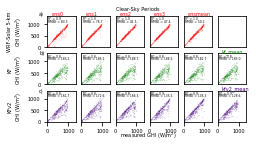

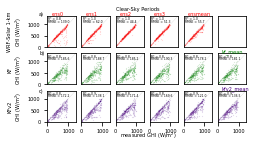

In [68]:
#row 1: ghi_mod

#row 2: 'GHI_pred_kf_only'

#row 3: 'GHI_pred_improved_fin'

def scat_clear(domain, da_mean):   
    da_mean = da_mean[da_mean['flag_clear'] == 'Y']
    
    li_gr = da_mean[da_mean['domain'] == str(domain)]
    li_gr = li_gr.groupby(['Time']).agg({'GHI_pred_kf_only':'mean','ghi_obs':'mean'}).reset_index()
    li_gr['kf_rmse'] = kf_fitting_pred(li_gr)[7]
    li_gr['kf_r'] = kf_fitting_pred(li_gr)[0]

    li_gr2 = da_mean[da_mean['domain'] == str(domain)]
    li_gr2 = li_gr2.groupby(['Time']).agg({'GHI_pred_improved_fin':'mean','ghi_obs':'mean'}).reset_index()
    li_gr2['kfp_rmse'] = fitting_pred(li_gr2)[7]
    li_gr2['kfp_r'] = fitting_pred(li_gr2)[0]
    
    x_new = np.linspace(0.01, 1360, 1000)
    fig = plt.figure()
    gs = fig.add_gridspec(6, 10)
    
    da_mean = da_mean[da_mean['domain'] == str(domain)]
    if domain == 'd01':
            res = 5
    elif domain == 'd02':
            res = 1
    jump = 1 #2   
    i_end = 3 #5
    j_end = 6 #9
    for i in range(0,i_end,jump):
        for j in range(0,j_end,jump):

            ax= fig.add_subplot(gs[i:i+1,j:j+1])


            if ((i == 0) | (i == 1)):
                ax.tick_params(axis='x', bottom=False,top=False,labelbottom=False) 
            if (j > 0):
                ax.tick_params(axis='y', left=False,right=False,labelleft=False) 

            if (j == 0):
                ens = 'ens0'
                back = da_mean[da_mean['ens'] == ens]
                
            if (j == 1):#2):
                ens = 'ens1'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 2):#4):
                ens = 'ens2'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 3):#6):
                ens = 'ens3'
                back = da_mean[da_mean['ens'] == ens]

            if (j == 4):#8):
                ens = 'ensmean'
                back = da_mean[da_mean['ens'] == ens]
            
            if ((i == 1) & (j == 5)):
                ens = 'kf_mean'
                back = li_gr
                back['pl'] = back['GHI_pred_kf_only']   

            if ((i == 2) & (j == 5)):
                ens = 'kfv2_mean'
                back = li_gr2
                back['pl'] = back['GHI_pred_improved_fin']   

            if ((i == 0) & (j != 5)):
                method = f'WRF-Solar {res}-km'
                color_= 'red'
                back['pl'] = back['ghi_mod']
                rmse = fitting(back)[7]
                r_ = fitting(back)[0]
            if (i == 1):#2):
                method = 'KF'
                color_= 'green'
                back['pl'] = back['GHI_pred_kf_only']   
                rmse = kf_fitting_pred(back)[7]
                r_ = kf_fitting_pred(back)[0]
            if ((i == 2)):#4):
                method = 'KFv2'
                color_= 'indigo'
                back['pl'] = back['GHI_pred_improved_fin']
                rmse = fitting_pred(back)[7]
                r_ = fitting_pred(back)[0]
            
            if (((i == 0) & (j != 5)) | ((i != 0) & (j <= 5))):
                
                
                ax.scatter(x=back['ghi_obs'],y=back['pl'],c=color_,s=0.01,alpha=0.5)
                plt.plot(x_new,x_new,c='gray',linewidth=0.1)
                ax.text( 50, 1100,'RMSE = %0.1f'%rmse, fontsize=3, color='black')
                ax.text( 50, 1200,'R* = %0.1f'%r_, fontsize=3, color='black')

                ax.tick_params(axis='both', which='major', labelsize=5)
                ax.set_ylim(0,1360)
                ax.set_xlim(0,1360)

                if (j==0):
                    ax.set_ylabel(f'{method}\nGHI (W/m$^2$)',  fontsize=5)  

                if (i==0) | ((i!=0 ) & (j==5)):
                    ax.text( 200, 1400,ens, fontsize=5, color=color_)
                if ((i==2) & (j==2)):
                    ax.text( 200, -700,f'measured GHI (W/m$^2$)', fontsize=5, color='k')
                if ((i==0) & (j==0)):
                    ax.text( -400, 1400,'a)', fontsize=5, color='k')
                if ((i==1) & (j==0)):
                    ax.text( -400, 1300,'b)', fontsize=5, color='k')
                if ((i==2) & (j==0)):
                    ax.text( -400, 1300,'c)', fontsize=5, color='k')
                if ((i==0) & (j==2)):
                    ax.text( 0, 1600,'Clear-Sky Periods', fontsize=5, color='k')

    plt.savefig(f"output/all_clear_Manila_scatplot_{res}km_{domain}.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_clear('d01',li)
scat_clear('d02',li)
